# CRISPR Off-Target Prediction Model
**Dataset:** CIRCLE-seq 10 gRNA Whole Dataset  
**Goal:** Predict whether a given sgRNA–off-target sequence pair causes true DNA cleavage (label=1) or not (label=0)  
**Strategy:**
1. Build ALL features first
2. Define ONE train/test split — used by every model
3. Compare models fairly on the same data
4. Evaluate best model → Cross-Validation → Threshold Tuning

---

## Section 1 — Imports
All libraries loaded once at the top.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

print("All imports done.")

All imports done.


## Section 2 — Load Data


In [2]:
df = pd.read_csv(r"CIRCLE_seq_10gRNA_wholeDataset.csv")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (584949, 7)
Columns: ['sgRNA_seq', 'off_seq', 'Read', 'sgRNA_type', 'Cell', 'Read_normalised', 'label']


,sgRNA_seq,off_seq,Read,sgRNA_type,Cell,Read_normalised,label
0,G_AGTCCGAGCAGAAGAAGAAAGG,GGAGTCCGTGCAGAAGCAGGAAGC,0.0,GAGTCCGAGCAGAAGAAGAANGG,,0.0,0.0
1,G_AGTCCGAGCAGAAGAAGAAAGG,CAAGTCCGAGAAGAAGCAGAAAAG,0.0,GAGTCCGAGCAGAAGAAGAANGG,,0.0,0.0
2,G_AGTCCGAGCAGAAGAAGAAAGG,GAAGTCTTAGCAAAAGAAGAAAGC,0.0,GAGTCCGAGCAGAAGAAGAANGG,,0.0,0.0
3,G_AGTCCGAGCAGAAGAAGAAAGG,GAAGTCCGAGGAGAGGAAGAAAGG,0.0,GAGTCCGAGCAGAAGAAGAANGG,,0.0,0.0
4,G_AGTCCGAGCAGAAGAAGAAAGG,GAAGGCGGAGAAGAAGAAGAAATT,0.0,GAGTCCGAGCAGAAGAAGAANGG,,0.0,0.0


## Section 3 — Class Distribution
Understanding the imbalance before doing anything else.

In [3]:
counts = df["label"].value_counts()
total  = len(df)

print("Label counts:")
print(counts)
print(f"\nPositive (cleavage) rate: {counts[1.0]/total*100:.2f}%")
print(f"Class imbalance ratio  : 1 : {int(counts[0.0]/counts[1.0])}")

Label counts:
label
0.0    577578
1.0      7371
Name: count, dtype: int64

Positive (cleavage) rate: 1.26%
Class imbalance ratio  : 1 : 78


## Section 4 — Sequence Length Check
Confirm all sequences are 24 bases (required for one-hot encoding).

In [4]:
print("sgRNA_seq lengths:", df["sgRNA_seq"].str.len().value_counts().to_dict())
print("off_seq lengths  :", df["off_seq"].str.len().value_counts().to_dict())

assert df["sgRNA_seq"].str.len().nunique() == 1, "sgRNA sequences are not all the same length!"
assert df["off_seq"].str.len().nunique()   == 1, "off-target sequences are not all the same length!"
print("\nAll sequences are exactly 24 bases. Ready for encoding.")

sgRNA_seq lengths: {24: 584949}
off_seq lengths  : {24: 584949}

All sequences are exactly 24 bases. Ready for encoding.


## Section 5 — Feature Engineering 1: Mismatch Count
Count positions where sgRNA and off-target sequence differ.

In [5]:
def count_mismatches(row):
    return sum(1 for a, b in zip(row["sgRNA_seq"], row["off_seq"]) if a != b)

df["mismatch_count"] = df.apply(count_mismatches, axis=1)

print("Mismatch count distribution:")
print(df["mismatch_count"].value_counts().sort_index())

Mismatch count distribution:
mismatch_count
0         9
1        23
2       182
3      2871
4     34294
5    150186
6    397383
7         1
Name: count, dtype: int64


## Section 6 — EDA: Mismatch Count vs Label
How does the number of mismatches relate to off-target cleavage probability?

label              0.0   1.0  positive_rate
mismatch_count                             
0                    9     0       0.000000
1                   19     4       0.173913
2                  119    63       0.346154
3                 2216   655       0.228144
4                32392  1902       0.055462
5               147821  2365       0.015747
6               395002  2381       0.005992
7                    0     1       1.000000


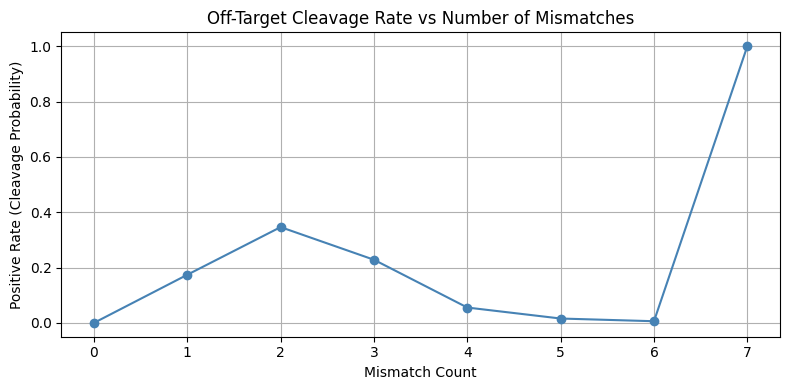

In [6]:
table = pd.crosstab(df["mismatch_count"], df["label"])
table["positive_rate"] = table[1.0] / (table[0.0] + table[1.0])

print(table)

plt.figure(figsize=(8, 4))
plt.plot(table.index, table["positive_rate"], marker="o", color="steelblue")
plt.xlabel("Mismatch Count")
plt.ylabel("Positive Rate (Cleavage Probability)")
plt.title("Off-Target Cleavage Rate vs Number of Mismatches")
plt.grid(True)
plt.tight_layout()
plt.show()

## Section 7 — Feature Engineering 2: GC Content
Fraction of G and C bases in each sequence.

In [7]:
def gc_content(seq):
    return (seq.count("G") + seq.count("C")) / len(seq)

df["sgRNA_GC"] = df["sgRNA_seq"].apply(gc_content)
df["off_GC"]   = df["off_seq"].apply(gc_content)

print("GC content stats:")
print(df[["sgRNA_GC", "off_GC"]].describe().round(4))

GC content stats:
          sgRNA_GC       off_GC
count  584949.0000  584949.0000
mean        0.6330       0.5657
std         0.0909       0.1196
min         0.4583       0.2083
25%         0.5833       0.5000
50%         0.6250       0.5417
75%         0.7083       0.6667
max         0.7917       0.9583


## Section 8 — Feature Engineering 3: One-Hot Encode sgRNA Sequences
Each of 24 positions → 4 binary columns (A, T, G, C) = **96 features**.

In [8]:
def one_hot_encode(seq):
    bases = ['A', 'T', 'G', 'C']
    return [1 if base == b else 0 for base in seq for b in bases]

sgRNA_df = pd.DataFrame(
    df["sgRNA_seq"].apply(one_hot_encode).tolist(),
    columns=[f"pos{i}_{b}" for i in range(24) for b in ['A','T','G','C']]
)

print("sgRNA one-hot shape:", sgRNA_df.shape)   # expected (584949, 96)
sgRNA_df.head(2)

sgRNA one-hot shape: (584949, 96)


,pos0_A,pos0_T,pos0_G,pos0_C,pos1_A,pos1_T,pos1_G,pos1_C,pos2_A,pos2_T,...,pos21_G,pos21_C,pos22_A,pos22_T,pos22_G,pos22_C,pos23_A,pos23_T,pos23_G,pos23_C
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


## Section 9 — Feature Engineering 4: One-Hot Encode Off-Target Sequences
Same encoding for the off-target sequence → another **96 features**.

In [9]:
off_df = pd.DataFrame(
    df["off_seq"].apply(one_hot_encode).tolist(),
    columns=[f"off_pos{i}_{b}" for i in range(24) for b in ['A','T','G','C']]
)

print("off-target one-hot shape:", off_df.shape)   # expected (584949, 96)

off-target one-hot shape: (584949, 96)


## Section 10 — Combine All Features into Final Feature Matrix
96 (sgRNA OHE) + 96 (off-target OHE) + 3 (mismatch, sgRNA_GC, off_GC) = **195 total features**.

In [10]:
X_full = pd.concat([
    sgRNA_df,
    off_df,
    df[["mismatch_count", "sgRNA_GC", "off_GC"]]
], axis=1).astype("float32")   # float32 saves memory

y = df["label"]

print("Final feature matrix shape:", X_full.shape)   # expected (584949, 195)
print("Label shape               :", y.shape)

Final feature matrix shape: (584949, 195)
Label shape               : (584949,)


## Section 11 — ONE Train / Test Split (Used by ALL Models)
⚠️ This split is defined **once** and reused consistently across every model below.

- Stratified to preserve the class ratio in both sets
- 80% train / 20% test

In [11]:
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_full, y,
    test_size=0.2,
    random_state=42,
    stratify=y          # preserves 1.25% positive rate in both sets
)

# Convenience slices for models that use fewer features
FEAT_MISMATCH   = ["mismatch_count"]
FEAT_MISMATCH_GC = ["mismatch_count", "sgRNA_GC", "off_GC"]

X_train_m   = X_train_full[FEAT_MISMATCH]
X_test_m    = X_test_full[FEAT_MISMATCH]

X_train_mgc = X_train_full[FEAT_MISMATCH_GC]
X_test_mgc  = X_test_full[FEAT_MISMATCH_GC]

print(f"Training set : {X_train_full.shape[0]:,} samples")
print(f"Test set     : {X_test_full.shape[0]:,} samples")
print(f"Positive rate in train: {y_train.mean()*100:.2f}%")
print(f"Positive rate in test : {y_test.mean()*100:.2f}%")

Training set : 467,959 samples
Test set     : 116,990 samples
Positive rate in train: 1.26%
Positive rate in test : 1.26%


## Section 12 — Model 1: Logistic Regression (Mismatch Count Only)
Simplest possible model — single feature baseline.

In [12]:
lr1 = LogisticRegression(class_weight="balanced", random_state=42)
lr1.fit(X_train_m, y_train)

y_pred_lr1 = lr1.predict(X_test_m)

print("=" * 55)
print(" Model 1: Logistic Regression — mismatch_count only")
print("=" * 55)
print(classification_report(y_test, y_pred_lr1))
print(f"ROC-AUC: {roc_auc_score(y_test, lr1.predict_proba(X_test_m)[:,1]):.4f}")

 Model 1: Logistic Regression — mismatch_count only
              precision    recall  f1-score   support

         0.0       0.99      0.68      0.81    115516
         1.0       0.03      0.67      0.05      1474

    accuracy                           0.68    116990
   macro avg       0.51      0.68      0.43    116990
weighted avg       0.98      0.68      0.80    116990

ROC-AUC: 0.7109


## Section 13 — Model 2: Logistic Regression (Mismatch + GC Content)
Adding GC content features — does it improve over single feature?

In [13]:
lr2 = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
lr2.fit(X_train_mgc, y_train)

y_pred_lr2 = lr2.predict(X_test_mgc)

print("=" * 57)
print(" Model 2: Logistic Regression — mismatch + GC content")
print("=" * 57)
print(classification_report(y_test, y_pred_lr2))
print(f"ROC-AUC: {roc_auc_score(y_test, lr2.predict_proba(X_test_mgc)[:,1]):.4f}")

print("\nFeature Coefficients:")
print(pd.Series(lr2.coef_[0], index=FEAT_MISMATCH_GC).sort_values(ascending=False))

 Model 2: Logistic Regression — mismatch + GC content
              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86    115516
         1.0       0.03      0.62      0.06      1474

    accuracy                           0.76    116990
   macro avg       0.51      0.69      0.46    116990
weighted avg       0.98      0.76      0.85    116990

ROC-AUC: 0.7747

Feature Coefficients:
sgRNA_GC          8.392644
mismatch_count   -1.278170
off_GC           -1.456751
dtype: float64


## Section 14 — Model 3: Random Forest (Mismatch + GC Content)
Tree-based model on the 3 numeric features — can it beat logistic regression?

In [14]:
rf_simple = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_simple.fit(X_train_mgc, y_train)

y_pred_rf_simple = rf_simple.predict(X_test_mgc)

print("=" * 57)
print(" Model 3: Random Forest — mismatch + GC content")
print("=" * 57)
print(classification_report(y_test, y_pred_rf_simple))
print(f"ROC-AUC: {roc_auc_score(y_test, rf_simple.predict_proba(X_test_mgc)[:,1]):.4f}")

print("\nFeature Importances:")
print(pd.Series(rf_simple.feature_importances_, index=FEAT_MISMATCH_GC).sort_values(ascending=False))

 Model 3: Random Forest — mismatch + GC content
              precision    recall  f1-score   support

         0.0       1.00      0.73      0.84    115516
         1.0       0.03      0.76      0.07      1474

    accuracy                           0.73    116990
   macro avg       0.52      0.75      0.45    116990
weighted avg       0.98      0.73      0.83    116990

ROC-AUC: 0.8160

Feature Importances:
mismatch_count    0.613541
sgRNA_GC          0.270387
off_GC            0.116072
dtype: float64


## Section 15 — Model 4: Random Forest (All 195 Features) — Best Model
Full feature set: one-hot encodings + mismatch count + GC content.

In [15]:
rf_full = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_full.fit(X_train_full, y_train)

y_pred_full = rf_full.predict(X_test_full)

print("=" * 55)
print(" Model 4: Random Forest — all 195 features")
print("=" * 55)
print(classification_report(y_test, y_pred_full))
print(f"ROC-AUC: {roc_auc_score(y_test, rf_full.predict_proba(X_test_full)[:,1]):.4f}")

 Model 4: Random Forest — all 195 features
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    115516
         1.0       0.90      0.36      0.52      1474

    accuracy                           0.99    116990
   macro avg       0.95      0.68      0.76    116990
weighted avg       0.99      0.99      0.99    116990

ROC-AUC: 0.9540


## Section 16 — Model Comparison Summary
Side-by-side ROC-AUC of all four models on the **same test set**.

Model Comparison — ROC-AUC on the SAME test set:
----------------------------------------
  LR — mismatch only     : 0.7109
  LR — mismatch + GC     : 0.7747
  RF — mismatch + GC     : 0.8160
  RF — all 195 feat      : 0.9540


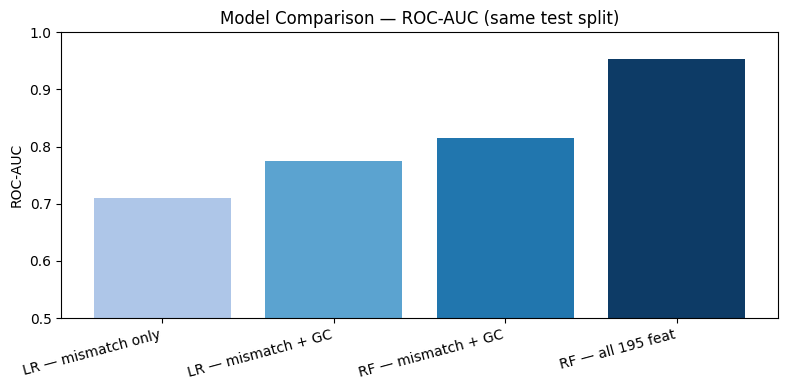

In [16]:
results = {
    "LR — mismatch only"  : roc_auc_score(y_test, lr1.predict_proba(X_test_m)[:,1]),
    "LR — mismatch + GC"  : roc_auc_score(y_test, lr2.predict_proba(X_test_mgc)[:,1]),
    "RF — mismatch + GC"  : roc_auc_score(y_test, rf_simple.predict_proba(X_test_mgc)[:,1]),
    "RF — all 195 feat"   : roc_auc_score(y_test, rf_full.predict_proba(X_test_full)[:,1]),
}

print("Model Comparison — ROC-AUC on the SAME test set:")
print("-" * 40)
for name, score in results.items():
    print(f"  {name:<22} : {score:.4f}")

plt.figure(figsize=(8, 4))
plt.bar(results.keys(), results.values(), color=["#aec6e8","#5ba3d0","#2176ae","#0d3b66"])
plt.ylim(0.5, 1.0)
plt.ylabel("ROC-AUC")
plt.title("Model Comparison — ROC-AUC (same test split)")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

## Section 17 — Best Model: Top 15 Feature Importances
Which features drive the Random Forest's decisions?

Top 15 Feature Importances:
mismatch_count    0.141838
off_pos23_G       0.077790
off_pos22_G       0.039325
off_pos1_G        0.036407
off_pos23_T       0.031647
off_GC            0.027791
off_pos23_C       0.022008
off_pos22_T       0.015858
off_pos22_C       0.014570
off_pos1_A        0.011267
sgRNA_GC          0.011000
off_pos2_A        0.009595
off_pos2_G        0.009269
pos0_G            0.008893
off_pos13_C       0.008749
dtype: float64


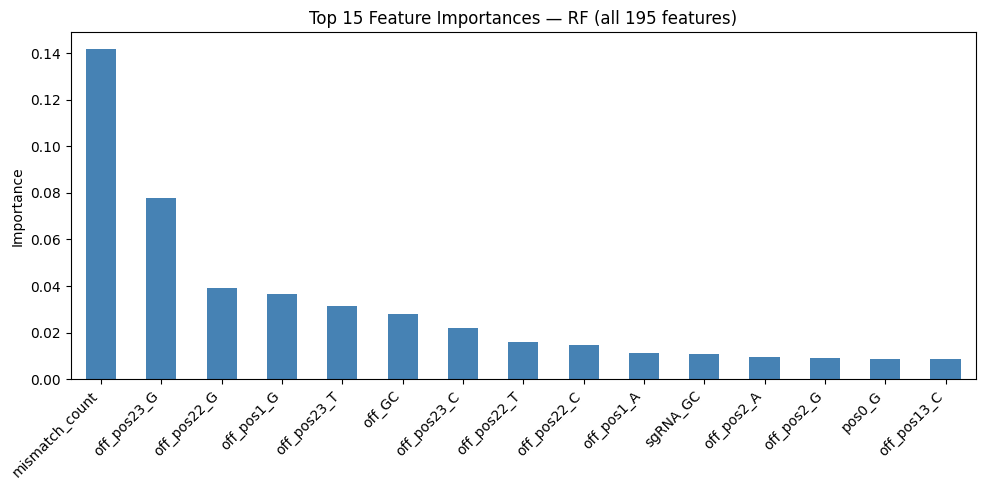

In [17]:
importances = pd.Series(rf_full.feature_importances_, index=X_full.columns)
top15 = importances.sort_values(ascending=False).head(15)

print("Top 15 Feature Importances:")
print(top15)

plt.figure(figsize=(10, 5))
top15.plot(kind="bar", color="steelblue")
plt.title("Top 15 Feature Importances — RF (all 195 features)")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Section 18 — Evaluation: ROC Curve
Using the best model (RF — all 195 features) and the same test set.

ROC-AUC: 0.9540


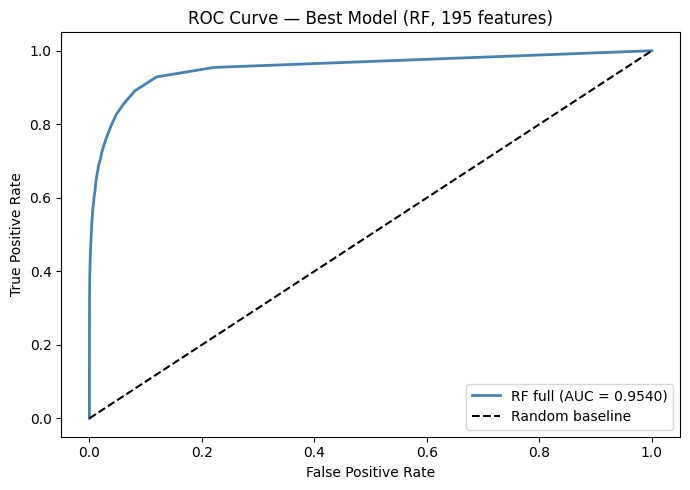

In [18]:
# Probabilities from the best model on the test set
y_prob = rf_full.predict_proba(X_test_full)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score   = roc_auc_score(y_test, y_prob)

print(f"ROC-AUC: {auc_score:.4f}")

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="steelblue", lw=2, label=f"RF full (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Best Model (RF, 195 features)")
plt.legend()
plt.tight_layout()
plt.show()

## Section 19 — Evaluation: Precision-Recall Curve
PR-AUC is more informative than ROC-AUC for heavily imbalanced datasets.

PR-AUC (Average Precision): 0.5995


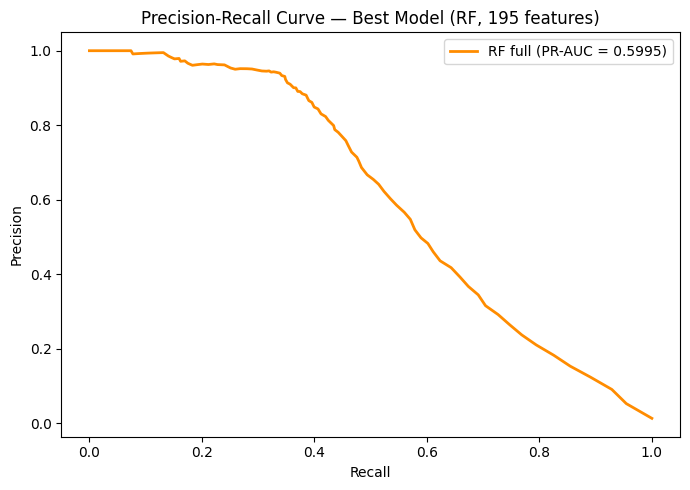

In [19]:
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

print(f"PR-AUC (Average Precision): {pr_auc:.4f}")

plt.figure(figsize=(7, 5))
plt.plot(recall_vals, precision_vals, color="darkorange", lw=2,
         label=f"RF full (PR-AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve — Best Model (RF, 195 features)")
plt.legend()
plt.tight_layout()
plt.show()

## Section 20 — Cross-Validation: ROC-AUC (3-Fold Stratified)
Confirms the model generalises — uses the **same rf_full model configuration** and **full X_full dataset**.

In [20]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Fresh estimator with same config as rf_full — CV fits its own copies internally
rf_for_cv = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42,
    n_jobs=1            # keep 1 on laptops to avoid memory issues
)

cv_roc = cross_val_score(
    rf_for_cv, X_full, y,
    cv=cv,
    scoring="roc_auc",
    n_jobs=1
)

print("Cross-Validation ROC-AUC (3-fold):")
print(f"  Fold scores : {cv_roc.round(4)}")
print(f"  Mean        : {cv_roc.mean():.4f}")
print(f"  Std         : {cv_roc.std():.4f}")

Cross-Validation ROC-AUC (3-fold):
  Fold scores : [0.9555 0.9562 0.9558]
  Mean        : 0.9558
  Std         : 0.0003


## Section 21 — Cross-Validation: PR-AUC (3-Fold Stratified)
Same CV object, same estimator configuration — only the scoring metric changes.

In [21]:
cv_pr = cross_val_score(
    rf_for_cv, X_full, y,
    cv=cv,
    scoring="average_precision",
    n_jobs=1
)

print("Cross-Validation PR-AUC (3-fold):")
print(f"  Fold scores : {cv_pr.round(4)}")
print(f"  Mean        : {cv_pr.mean():.4f}")
print(f"  Std         : {cv_pr.std():.4f}")

Cross-Validation PR-AUC (3-fold):
  Fold scores : [0.5782 0.5731 0.5917]
  Mean        : 0.5810
  Std         : 0.0078


## Section 22 — Threshold Tuning: Test Threshold = 0.3
The default 0.5 threshold is suboptimal when classes are imbalanced.

⚠️ All threshold tests use `y_prob` computed in **Section 18** (rf_full on the same test set).

In [22]:
t = 0.3
y_pred_t03 = (y_prob > t).astype(int)

print(f"Classification Report — threshold = {t}:")
print(classification_report(y_test, y_pred_t03))

Classification Report — threshold = 0.3:


              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    115516
         1.0       0.73      0.47      0.57      1474

    accuracy                           0.99    116990
   macro avg       0.86      0.73      0.78    116990
weighted avg       0.99      0.99      0.99    116990



## Section 23 — Threshold Tuning: Test Threshold = 0.2

In [23]:
t = 0.2
y_pred_t02 = (y_prob > t).astype(int)

print(f"Classification Report — threshold = {t}:")
print(classification_report(y_test, y_pred_t02))

Classification Report — threshold = 0.2:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    115516
         1.0       0.57      0.56      0.56      1474

    accuracy                           0.99    116990
   macro avg       0.78      0.78      0.78    116990
weighted avg       0.99      0.99      0.99    116990



## Section 24 — Find Optimal Threshold (Maximises F1 Score)
Systematically search every threshold from the PR curve and pick the one with the highest F1.

In [24]:
prec_vals, rec_vals, thresholds = precision_recall_curve(y_test, y_prob)

# F1 at every threshold
f1_scores = 2 * (prec_vals * rec_vals) / (prec_vals + rec_vals + 1e-8)

best_idx       = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Optimal Threshold Search Results:")
print(f"  Best threshold : {best_threshold:.4f}")
print(f"  Best F1        : {f1_scores[best_idx]:.4f}")
print(f"  Precision      : {prec_vals[best_idx]:.4f}")
print(f"  Recall         : {rec_vals[best_idx]:.4f}")

Optimal Threshold Search Results:
  Best threshold : 0.3000
  Best F1        : 0.5708
  Precision      : 0.7138
  Recall         : 0.4756


## Section 25 — Final Evaluation at Optimal Threshold
Apply the best threshold found in Section 24.

In [25]:
y_pred_optimal = (y_prob > best_threshold).astype(int)

print(f"Final Classification Report — optimal threshold = {best_threshold:.4f}")
print("=" * 60)
print(classification_report(y_test, y_pred_optimal))

Final Classification Report — optimal threshold = 0.3000
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    115516
         1.0       0.73      0.47      0.57      1474

    accuracy                           0.99    116990
   macro avg       0.86      0.73      0.78    116990
weighted avg       0.99      0.99      0.99    116990



## Section 26 — Final Summary
Complete picture of what was built and achieved.

In [26]:
print("=" * 60)
print("   CRISPR Off-Target Prediction — Final Summary")
print("=" * 60)
print(f"Dataset          : {df.shape[0]:,} sgRNA–off-target pairs")
print(f"Positive rate    : {y.mean()*100:.2f}% (severe imbalance)")
print(f"Features used    : 195 (96 sgRNA OHE + 96 off-target OHE + 3 numeric)")
print(f"Train/Test split : 80/20 — stratified, random_state=42")
print()
print("Model Comparison (ROC-AUC on same test set):")
for name, score in results.items():
    print(f"  {name:<22} : {score:.4f}")
print()
print("Best Model: Random Forest — all 195 features")
print(f"  ROC-AUC            : {auc_score:.4f}")
print(f"  PR-AUC             : {pr_auc:.4f}")
print(f"  CV ROC-AUC (mean)  : {cv_roc.mean():.4f} ± {cv_roc.std():.4f}")
print(f"  CV PR-AUC  (mean)  : {cv_pr.mean():.4f} ± {cv_pr.std():.4f}")
print(f"  Optimal threshold  : {best_threshold:.4f}")
print(f"  F1 at opt threshold: {f1_scores[best_idx]:.4f}")
print("=" * 60)

   CRISPR Off-Target Prediction — Final Summary
Dataset          : 584,949 sgRNA–off-target pairs
Positive rate    : 1.26% (severe imbalance)
Features used    : 195 (96 sgRNA OHE + 96 off-target OHE + 3 numeric)
Train/Test split : 80/20 — stratified, random_state=42

Model Comparison (ROC-AUC on same test set):
  LR — mismatch only     : 0.7109
  LR — mismatch + GC     : 0.7747
  RF — mismatch + GC     : 0.8160
  RF — all 195 feat      : 0.9540

Best Model: Random Forest — all 195 features
  ROC-AUC            : 0.9540
  PR-AUC             : 0.5995
  CV ROC-AUC (mean)  : 0.9558 ± 0.0003
  CV PR-AUC  (mean)  : 0.5810 ± 0.0078
  Optimal threshold  : 0.3000
  F1 at opt threshold: 0.5708
